# SPD Refactor

## Setup

In [2]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import einops
import typing
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
wandb.login()

<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lgngrvs (lgngrvs-independent) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [41]:
DEVICE = "cuda"
CONFIG = {
    "num_layers": 1,
    "pre_embed_size": 100,
    "in_size": 1000,
    "hidden_size": 50,
    "subcomponents_per_layer": 120,
    "beta_1": 1.0,
    "beta_2": 1.0,
    "beta_3": 0.1,
    "causal_imp_min": 1.0,
    "num_mask_samples": 50,
    "importance_mlp_size": 10,
}
TRAIN_CONFIG = {
    "lr": 2e-3,
    "lr_step_size": 8,
    "lr_gamma": 0.5,
}
BATCH_SIZE=32
NUM_EPOCHS=25

## Defining and testing toy model to decompose

In [16]:
toy_config = {
    "num_layers": 1,
    "pre_embed_size": 100,
    "in_size": 1000,
    "hidden_size": 50,
}

toy_train_config = {
    "lr": 4e-3,
    "lr_step_size": 3,
    "lr_gamma": 0.5,
    "num_epochs": 12
}

In [17]:
class ToyResidMLP(nn.Module):
    def __init__(self, config, device="cpu"):
        super().__init__()
        # Initialize Weights for the
        self.num_layers, self.pre_embed_size, self.in_size, self.hidden_size = config["num_layers"], config["pre_embed_size"], config["in_size"], config["hidden_size"]
        self.device = device
        #self.W_embed = nn.Parameter(torch.empty((self.pre_embed_size, self.in_size)))
        #self.W_unembed = nn.Parameter(torch.empty((self.in_size, self.pre_embed_size)))
        self.W_embed = torch.randn((self.pre_embed_size, self.in_size), device=device)
        self.W_embed = self.W_embed / self.W_embed.norm(dim=1, keepdim=True)
        self.W_unembed = self.W_embed.T

        self.W_in = nn.ParameterList([torch.empty((self.in_size, self.hidden_size), device=device) for i in range(self.num_layers)])
        self.W_out = nn.ParameterList([torch.empty((self.hidden_size, self.in_size), device=device) for i in range(self.num_layers)])
        self.b = nn.ParameterList([torch.zeros((self.hidden_size,), device=device) for i in range(self.num_layers)])

        for param in [self.W_embed, self.W_unembed] + list(self.W_in) + list(self.W_out):
            nn.init.xavier_normal_(param)

    def forward(self, x):

        assert x.shape[1] == self.pre_embed_size, f"Input shape {x.shape[0]} does not match model's accepted size {self.pre_embed_size}"
        # embed
        x_resid = torch.einsum("np,pi->ni", x.clone(), self.W_embed)
        N, D = x_resid.shape

        for l in range(self.num_layers):
            hidden = F.relu(torch.einsum("nd,dh -> nh", x_resid, self.W_in[l]) + self.b[l])
            layer_out = torch.einsum("nh,hd -> nd", hidden, self.W_out[l])
            x_resid = x_resid + layer_out
        # am I supposed to have a embed and out?
        x_out = torch.einsum("ni,ip->np", x_resid, self.W_unembed)
        return x_out


# I vibecoded this originally, and regretted it.
class SparseAutoencoderDataset(Dataset):
    def __init__(self, in_dim=100, n_samples=10000, sparsity=0.9, device="cpu"):
        super().__init__()
        self.in_dim = in_dim
        self.n_samples = n_samples
        self.device = device

        # Pre-generate all samples
        self.inputs = []
        self.targets = []

        for _ in range(n_samples):
            x = np.random.uniform(-1, 1, size=(in_dim))
            mask = np.random.rand(in_dim) > sparsity  # 1-sparsity fraction will be nonzero
            x = x * mask
            x = torch.tensor(x, dtype=torch.float32, device=device)

            target = x + F.relu(x)

            self.inputs.append(x)
            self.targets.append(target)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

def train_toy_resid_mlp(
    model,
    dataloader,
    lr=1e-3,
    num_epochs=10,
    device="cuda",
    print_every=1
):
    model.train()
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.StepLR(
      optimizer,
      step_size=toy_train_config["lr_step_size"],
      gamma=toy_train_config["lr_gamma"]
    )

    loss_fn = nn.MSELoss()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
            run.log({"loss":loss})
        avg_loss = total_loss / len(dataloader.dataset)
        if (epoch+1) % print_every == 0:
            print(f"Epoch {epoch+1}: avg MSE loss = {avg_loss:.6f}")
        scheduler.step()
    run.finish()


## LLM-Generated Usage Example
if __name__ == "__main__":
    device=DEVICE
    config=CONFIG


    run = wandb.init(
        reinit="create_new",
        entity="lgngrvs-independent",
        project="spd",
        config = toy_config | toy_train_config # Join dicts
    )

    dataset = SparseAutoencoderDataset(
        in_dim=100,
        n_samples=131072,
        sparsity=0.7,
        device=device,
    )

    print(device)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    # Model
    toy_model = ToyResidMLP(config, device=device)
    # Train
    train_toy_resid_mlp(toy_model, dataloader, lr=toy_train_config["lr"], num_epochs=toy_train_config["num_epochs"], device=device)

cuda


Epoch 1/12: 100%|██████████| 1024/1024 [00:02<00:00, 360.53it/s]


Epoch 1: avg MSE loss = 0.025870


Epoch 2/12: 100%|██████████| 1024/1024 [00:02<00:00, 413.72it/s]


Epoch 2: avg MSE loss = 0.024044


Epoch 3/12: 100%|██████████| 1024/1024 [00:02<00:00, 421.86it/s]


Epoch 3: avg MSE loss = 0.024030


Epoch 4/12: 100%|██████████| 1024/1024 [00:02<00:00, 423.87it/s]


Epoch 4: avg MSE loss = 0.022549


Epoch 5/12: 100%|██████████| 1024/1024 [00:02<00:00, 428.09it/s]


Epoch 5: avg MSE loss = 0.022579


Epoch 6/12: 100%|██████████| 1024/1024 [00:02<00:00, 422.84it/s]


Epoch 6: avg MSE loss = 0.022599


Epoch 7/12: 100%|██████████| 1024/1024 [00:02<00:00, 416.50it/s]


Epoch 7: avg MSE loss = 0.021868


Epoch 8/12: 100%|██████████| 1024/1024 [00:02<00:00, 427.17it/s]


Epoch 8: avg MSE loss = 0.021872


Epoch 9/12: 100%|██████████| 1024/1024 [00:02<00:00, 430.89it/s]


Epoch 9: avg MSE loss = 0.021874


Epoch 10/12: 100%|██████████| 1024/1024 [00:02<00:00, 432.05it/s]


Epoch 10: avg MSE loss = 0.021500


Epoch 11/12: 100%|██████████| 1024/1024 [00:02<00:00, 428.13it/s]


Epoch 11: avg MSE loss = 0.021496


Epoch 12/12: 100%|██████████| 1024/1024 [00:02<00:00, 417.36it/s]

Epoch 12: avg MSE loss = 0.021494


loss,█▆▄▃▃▄▃▄▃▃▃▄▂▃▂▃▂▂▃▃▂▁▁▂▂▂▂▂▂▁▂▂▂▁▁▂▁▂▁▂
loss,0.02193


Input: tensor([-0.0932, -0.0000,  0.3140, -0.0000, -0.3900], device='cuda:0')
Target (ReLU): tensor([-0.0932,  0.0000,  0.6280,  0.0000, -0.3900], device='cuda:0')
Model output: tensor([-0.0202, -0.0624,  0.5502, -0.1173, -0.4798], device='cuda:0')


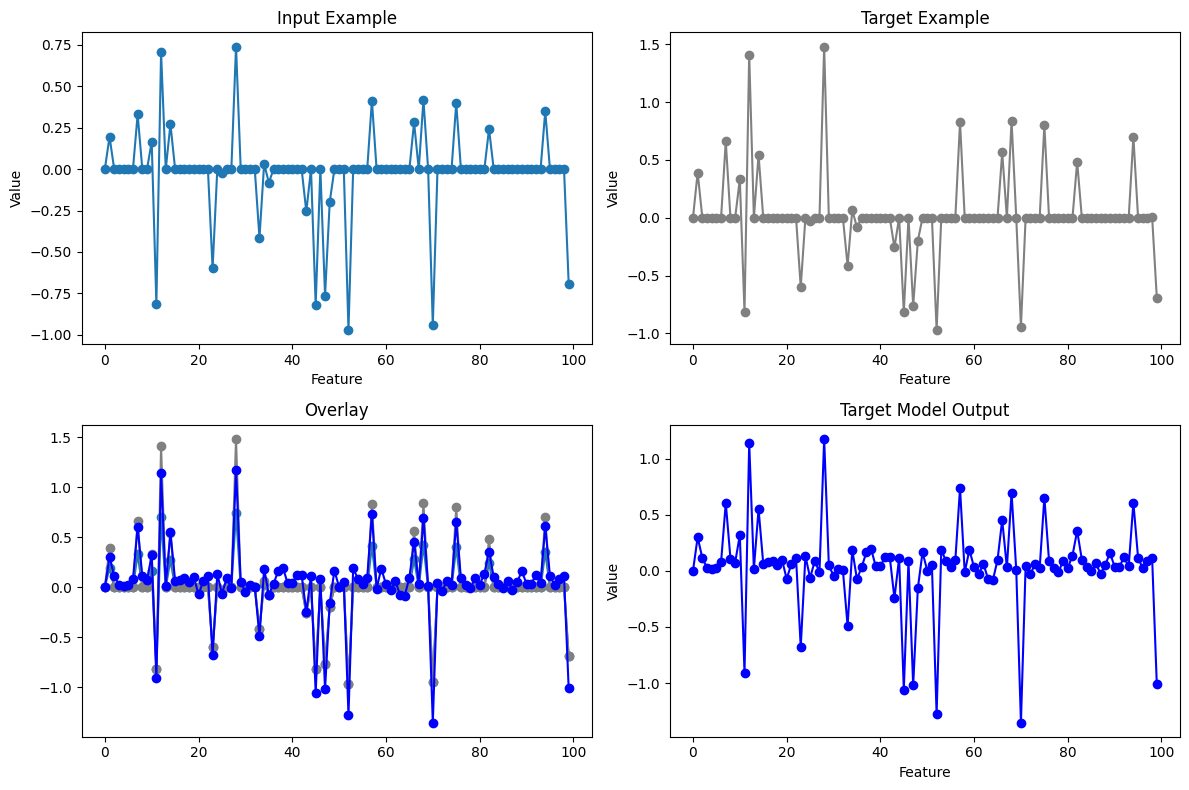

In [18]:
eval_dataset = SparseAutoencoderDataset(
    in_dim=100,
    n_samples=100,
    sparsity=0.7,
    device=device,
)

def visualize_model_outputs(toy_model, dataloader, device="cuda", idx=0):
    """
    Visualize the outputs of the SPD model and its target model on a single evaluation example.

    Args:
        model: SPDModelMLP instance (should have .target_model attribute)
        dataloader: DataLoader yielding (inputs, targets)
        device: Device to run the model on
        idx: Index of the example in the batch to visualize
    """
    # Get a batch from the dataloader
    batch = next(iter(dataloader))
    x, y = batch[0].to(device), batch[1].to(device)

    # Run both models on the batch
    with torch.no_grad():
        toy_out = toy_model(x)

    # Select the example to visualize
    target_out_example = toy_out[idx].detach().cpu().numpy()
    input_example = x[idx].detach().cpu().numpy()
    target_example = y[idx].detach().cpu().numpy()

    # Plot all outputs for comparison
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Input
    axes[0, 0].plot(input_example, marker='o')
    axes[0, 0].set_title("Input Example")
    axes[0, 0].set_xlabel("Feature")
    axes[0, 0].set_ylabel("Value")

    # Target
    axes[0, 1].plot(target_example, marker='o', color='gray')
    axes[0, 1].set_title("Target Example")
    axes[0, 1].set_xlabel("Feature")
    axes[0, 1].set_ylabel("Value")

    # Target Model Output
    axes[1, 1].plot(target_out_example, marker='o', color='blue')
    axes[1, 1].set_title("Target Model Output")
    axes[1, 1].set_xlabel("Feature")
    axes[1, 1].set_ylabel("Value")

    # Target Model Output
    axes[1, 0].plot(input_example, marker='o')
    axes[1, 0].plot(target_example, marker='o', color='gray')
    axes[1, 0].plot(target_out_example, marker='o', color='blue')
    axes[1, 0].set_title("Overlay")

    plt.tight_layout()
    plt.show()

# Pick a sample with negative values
sample_input, sample_target = dataset[5]
with torch.no_grad():
    output = toy_model(sample_input.unsqueeze(0)).squeeze()

# Check a few values
print(f"Input: {sample_input[:5]}")
print(f"Target (ReLU): {sample_target[:5]}")
print(f"Model output: {output[:5]}")
# Example usage:
visualize_model_outputs(toy_model, dataloader, device=DEVICE, idx=10)


## Training and evaluating SPD model

In [19]:
class Subcomponent(nn.Module):
    # Subcomponents approximate a in_dim x out_dim matrix with c components
    def __init__(self, shape, num_components, device="cuda"):
        super().__init__()
        self.in_dims = shape[0]
        self.out_dims = shape[1]
        self.shape = shape
        self.C = num_components
        self.device=device

        self.V = nn.Parameter(torch.empty((self.in_dims, self.C), device=device))
        self.U = nn.Parameter(torch.empty((self.C, self.out_dims), device=device))

        nn.init.xavier_normal_(self.V)
        nn.init.xavier_normal_(self.U)

    def forward(self, x, mask=None):
        # self is shape (in_dims, C), (C, out_dims) -> (in_dims, out_dims)
        # x is shape (N, in_dims)
        # mask is shape (N, C)
        N, in_dims = x.shape

        if mask is None:
            activations = x @ self.V
        else:
            activations = x @ self.V * mask
        out = activations @ self.U

        return out, activations

    def return_weights(self):
        weights = self.V @ self.U
        return weights

In [20]:
class ImportancePredictor(nn.Module):
    def __init__(self, hidden_size, num_components, device="cuda"):
        super().__init__()
        self.hidden_size = hidden_size
        self.C = num_components
        self.device = device

        # These are techncially (C, hidden, 1) and (C, 1, hidden)
        # but squeezing and unsqueezing is less efficient
        self.W_gate_in = nn.Parameter(torch.empty((self.C, hidden_size), device=device))
        self.W_gate_out = nn.Parameter(torch.empty((self.C, hidden_size), device=device))

        # I think that nonzero biases will be easier to learn
        self.b_in = nn.Parameter(torch.zeros((self.C, hidden_size), device=device) + 0.1)
        self.b_out = nn.Parameter(torch.zeros((self.C,), device=device) + 0.1) # technically shape (C, 1)

        nn.init.xavier_normal_(self.W_gate_in)
        nn.init.xavier_normal_(self.W_gate_out)


    def forward(self, subcomponent_activations):
        # Activations are shape (N, C) (see Subcomponent.forward)
        # In_weights are shape (C, hidden_size)
        hidden = F.gelu(torch.einsum("nc,cs->ncs", subcomponent_activations, self.W_gate_in) + self.b_in)
        prediction_out = torch.einsum("ncs,cs->nc", hidden, self.W_gate_out) + self.b_out

        return prediction_out # now shape (N,C). Unsqueeze to get (N,C,1)

In [21]:
class MLPSubcomponentLayer(nn.Module):
    def __init__(self, embed_size, hidden_size, num_components, device="cuda"):
        super().__init__()

        # "in matrix" since `in` is a builtin thing
        self.in_mat = Subcomponent((embed_size, hidden_size), num_components, device=device)
        self.out_mat = Subcomponent((hidden_size, embed_size), num_components, device=device)
        self.bias = nn.Parameter(torch.zeros((1, hidden_size,), device=device))

    def forward(self, x, masks=None):
        # Mask should be dict {in: (N, C), out: (N,C)}
        if masks is None:
            masks={"in": None, "out": None} # So that mask[0] won't break; instead will pass None in which is ok
        mat_output, activs_in = self.in_mat(x, masks["in"])
        hidden= F.relu(mat_output + self.bias)
        out, activs_out = self.out_mat(hidden, masks["out"])
        return out, {"in": activs_in, "out": activs_out}

    def return_weights_layer(self):
        return {"in": self.in_mat.return_weights(), "out": self.out_mat.return_weights()}


In [22]:
class SPDModelMLP(nn.Module):
    def __init__(self, target_model, config, device="cuda"):
        super().__init__()
        self.device = device
        object.__setattr__(self, "target_model", target_model) # sets pointer to target_model without registering its parameters as subsidiary

        # Unpack Config
        self.C, self.num_layers, self.pre_embed_size, self.embed_size, self.hidden_size, self.imp_hidden_size = config["subcomponents_per_layer"], config["num_layers"], config["pre_embed_size"], config["in_size"], config["hidden_size"], config["importance_mlp_size"]
        self.hypers = dict(list(config.items())[4:])
        self.num_matrices = self.num_layers * 2 + 2
        self.P = sum(p.numel() for p in self.target_model.parameters())


        # Define weights/subcomponents
        self.embed = Subcomponent((self.pre_embed_size, self.embed_size), self.C, device=device)
        self.unembed = Subcomponent((self.embed_size, self.pre_embed_size), self.C, device=device)

        self.layers = nn.ModuleList(
            MLPSubcomponentLayer(self.embed_size, self.hidden_size, self.C, device=device) for _ in range(self.num_layers)
        )

        # Define Importance Predictors
        # You can index importance predictors via imp_pred_ers[layer]["in"/"out"]
        self.imp_pred_ers = nn.ModuleList(
            [nn.ModuleDict({
                name: ImportancePredictor(self.imp_hidden_size, self.C, device=device) for name in ["in", "out"]
            }) for l in range(self.num_layers)] +
            [nn.ModuleDict({
                name: ImportancePredictor(self.imp_hidden_size, self.C, device=device) for name in ["embed", "unembed"]
            })]
        )

    def forward(self, x, masks=None, return_activs_weights=False):
        # Create the masks object so that dict keys never break (simplifies code)
        if masks is None:
            layer_masks = [
                { name: None for name in ("in", "out") }
                for _ in range(self.num_layers)
            ]
            end_masks = { name: None for name in ("embed", "unembed") }
            masks = layer_masks + [end_masks]


        activations = []

        # regular forward pass
        x, embed_activs = self.embed(x, masks[-1]["embed"])
        for l in range(self.num_layers):
            x, layer_activations = self.layers[l](x, masks=masks[l])
            activations.append(layer_activations)

        x, unembed_activs = self.unembed(x, masks[-1]["unembed"])
        activations.append({"embed": embed_activs, "unembed": unembed_activs})


        if not return_activs_weights:
            return x
        else:
            weights = []

            for l in range(self.num_layers):
                weights.append(self.layers[l].return_weights_layer())
            weights.append({"embed": self.embed.return_weights(), "unembed": self.unembed.return_weights()})

            return x, activations, weights

In [23]:
class HardSigmoid(nn.Module):
    """
    Implements the hard sigmoid activation function as described in the paper:
        σ_H(x) = 0 if x <= 0
               = x if 0 < x < 1
               = 1 if x >= 1
    This is equivalent to: torch.clamp(x, min=0.0, max=1.0)
    """
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # Clamp values between 0 and 1
        return torch.clamp(x, min=0.0, max=1.0)


class LowerLeakyHardSigmoid(nn.Module):
    """
    Lower-leaky hard sigmoid: σH,lower(x)
    - 0.01*x if x <= 0 (leaky below 0)
    - x if 0 <= x <= 1 (linear in middle)
    - 1 if x >= 1 (saturated above 1)

    Used for forward pass masks in stochastic reconstruction losses.
    """
    def __init__(self, leak_slope=0.01):
        super().__init__()
        self.leak_slope = leak_slope

    def forward(self, x):
        return torch.where(
            x <= 0,
            self.leak_slope * x,
            torch.where(
                x >= 1,
                torch.ones_like(x),
                x
            )
        )

class UpperLeakyHardSigmoid(nn.Module):
    """
    Upper-leaky hard sigmoid: σH,upper(x)
    - 0 if x <= 0 (hard cutoff below 0)
    - x if 0 <= x <= 1 (linear in middle)
    - 1 + 0.01*(x-1) if x >= 1 (leaky above 1)

    Used for importance loss computation.
    """
    def __init__(self, leak_slope=0.01):
        super().__init__()
        self.leak_slope = leak_slope

    def forward(self, x):
        return torch.where(
            x <= 0,
            torch.zeros_like(x),
            torch.where(
                x >= 1,
                1 + self.leak_slope * (x - 1),
                x
            )
        )

In [32]:
def train_spd(spd_model, dataloader, train_config, num_epochs=1):

    # SPD model is a model
    spd_model.train()
    print(f"Training on device {spd_model.device}")
    optimizer = torch.optim.AdamW(spd_model.parameters(), lr = train_config["lr"])

    """scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=train_config["lr_step_size"],   # e.g. every 4 epochs
        gamma=train_config["lr_gamma"]      # multiply LR by 0.5 each time
    )"""

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience = 2,

    )

    # P = sum(p.numel() for p in spd_model.target_model.parameters()) [moved into model]
    upper_leaky_sigmoid = UpperLeakyHardSigmoid()
    lower_leaky_sigmoid = LowerLeakyHardSigmoid()

    for epoch in range(num_epochs):
        total_loss = 0.0
        total_l_stoch_rec, total_l_stoch_rec_l, total_l_imp, total_l_faith = 0.0, 0.0, 0.0, 0.0
        epoch_lr = f"{optimizer.param_groups[0]['lr']:.2e}"
        print(f"Starting epoch {epoch+1}, lr = {epoch_lr}")

        with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as t:
            for batch_idx, (x,y) in enumerate(t):
                x = x.to(device)
                y = y.to(device)

                N = x.shape[0]     # x is shape N by in_size
                S, C, P, L = spd_model.hypers["num_mask_samples"], spd_model.C, spd_model.P, spd_model.num_layers
                target_model = spd_model.target_model
                optimizer.zero_grad()

                # ====== TARGET MODEL OUTPUT ======
                with torch.no_grad():
                    target_out = spd_model.target_model(x)

                # ====== FAITHFULNESS LOSS ======
                spd_output, spd_activations, spd_weights = spd_model(x, return_activs_weights = True)
                squared_error = 0

                for l in range(L):
                    in_diff = target_model.W_in[l] - spd_weights[l]["in"]
                    out_diff = target_model.W_out[l] - spd_weights[l]["out"]
                    squared_error_layer = torch.linalg.matrix_norm(in_diff)**2 + torch.linalg.matrix_norm(out_diff)**2
                    squared_error = squared_error + squared_error_layer

                embed_diff = target_model.W_embed - spd_weights[-1]["embed"]
                unembed_diff = target_model.W_unembed - spd_weights[-1]["unembed"]
                squared_error_embed = torch.linalg.matrix_norm(embed_diff)**2 + torch.linalg.matrix_norm(unembed_diff)**2
                squared_error = squared_error + squared_error_embed

                l_faithfulness = squared_error/P # "Mean Squared Error" across parameters


                # ===== IMPORTANCE MINIMALITY LOSS ======
                l_importance_minimality = 0.0

                pred_importances = []

                imp_pred_embed = spd_model.imp_pred_ers[-1]["embed"](spd_activations[-1]["embed"])
                imp_pred_unembed = spd_model.imp_pred_ers[-1]["unembed"](spd_activations[-1]["unembed"])
                l_importance_minimality = l_importance_minimality + (upper_leaky_sigmoid(imp_pred_embed)** spd_model.hypers["causal_imp_min"]).sum() + (upper_leaky_sigmoid(imp_pred_unembed) ** spd_model.hypers["causal_imp_min"]).sum()
                for l in range(L):
                    imp_pred_in = spd_model.imp_pred_ers[l]["in"](spd_activations[l]["in"])
                    imp_pred_out = spd_model.imp_pred_ers[l]["out"](spd_activations[l]["out"])
                    pred_importances.append({"in": imp_pred_in, "out": imp_pred_out})
                    l_importance_minimality = l_importance_minimality + (upper_leaky_sigmoid(imp_pred_in) ** spd_model.hypers["causal_imp_min"]).sum()  + (upper_leaky_sigmoid(imp_pred_out)** spd_model.hypers["causal_imp_min"]).sum()
                pred_importances.append({"embed": imp_pred_embed, "unembed": imp_pred_unembed})

                l_importance_minimality /= N


                # ===== STOCHASTIC RECONSTRUCTION LOSS ======
                l_stochastic_recon = 0.0
                l_stochastic_recon_layerwise = 0.0
                R = torch.rand((S, N, L+1, 2, C), device=device)

                # we have activs in shape (N,C). Stack and unsqueeze(0) to (1,2,N,C) and cat along dim 1 to get (L+1,2,N,C)
                stacked_imps = torch.cat([torch.stack((pred_importances[l]["in"], pred_importances[l]["out"])).reshape(1,2,N,C) for l in range(L)] + [torch.stack((pred_importances[-1]["embed"],pred_importances[-1]["unembed"])).reshape(1,2,N,C)])
                # reshape (L+1, 2, N, C) -> (N, L+1, 2, C)
                stacked_imps = torch.movedim(stacked_imps, 2, 0)
                # Apply sigmoid and then reshape to (1, N, L+1, 2, C)
                G = lower_leaky_sigmoid(stacked_imps).unsqueeze(0)
                masks = G + (1-G)*R # shape (S, N, L+1, 2, C)
                masks = masks.reshape(S*N, L+1, 2, C)

                # Move masks back into layerwise structure
                layer_masks = [
                    { name: masks[:,l,idx,:] for name, idx in [("in",0), ("out",1)] } for l in range(L)
                ]
                end_masks = { name: masks[:,l+1,idx,:] for name, idx in [("embed", 0), ("unembed", 1)] }
                masks_dictified = layer_masks + [end_masks]

                #Tile inputs (1, N, embed_size) S times to have N_new = S * N -> (N * S, embed_size)
                x_repeated = x.clone().unsqueeze(0).expand(S, -1, -1).reshape(S * N, -1)

                # Run regular masked loss and update stochastic recon
                masked_out = spd_model(x_repeated, masks=masks_dictified)
                target_out_tiled = target_out.clone().unsqueeze(0).expand(S, -1, -1).reshape(S*N, -1)
                l_stochastic_recon = l_stochastic_recon + torch.linalg.matrix_norm(target_out_tiled-masked_out)**2
                l_stochastic_recon /= S

                # ===== STOCHASTIC RECONSTRUCTION LAYERWISE LOSS ======
                # Create Layerwise Mask constructor
                layer_masks_none = [
                    { name: None for name in ("in", "out") }
                    for _ in range(L)
                ]
                end_masks_none = { name: None for name in ("embed", "unembed") }
                layer_mask_constructor = layer_masks_none + [end_masks_none]

                # Embed and unembed outs
                embed_mask = layer_mask_constructor.copy()
                embed_mask[-1]["embed"] = masks_dictified[-1]["embed"]
                embed_out=spd_model(x_repeated, embed_mask)

                unembed_mask = layer_mask_constructor.copy()
                unembed_mask[-1]["unembed"] = masks_dictified[-1]["unembed"]
                unembed_out=spd_model(x_repeated,unembed_mask)
                l_stochastic_recon_layerwise = l_stochastic_recon_layerwise + torch.linalg.matrix_norm(target_out_tiled-embed_out)**2 + torch.linalg.matrix_norm(target_out_tiled-unembed_out)**2

                for l in range(L):
                    for name in ["in", "out"]:
                        layer_mask = layer_mask_constructor.copy()
                        layer_mask[l][name] = masks_dictified[l][name]
                        layer_out = spd_model(x_repeated,layer_mask)
                        l_stochastic_recon_layerwise = l_stochastic_recon_layerwise + torch.linalg.matrix_norm(target_out_tiled-layer_out)**2

                l_stochastic_recon_layerwise /= (S * spd_model.num_matrices)

                beta1, beta2, beta3 = spd_model.hypers["beta_1"], spd_model.hypers["beta_2"], spd_model.hypers["beta_3"]

                # Loss computations
                loss = l_faithfulness + beta1*l_stochastic_recon + beta2*l_stochastic_recon_layerwise + beta3*l_importance_minimality
                loss = loss / BATCH_SIZE
                run.log({"lr": float(epoch_lr), "loss": loss, "l_faithfulness": l_faithfulness, "l_stochastic_recon": l_stochastic_recon, "l_stochastic_recon_layerwise": l_stochastic_recon_layerwise, "l_importance_minimality": l_importance_minimality})
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(spd_model.parameters(), max_norm=1.0)
                optimizer.step()
                t.set_postfix(loss=loss.item())
            print(f"(Last batch) Faithfulness: {l_faithfulness}, Stoch Rec: {l_stochastic_recon}, Stoch Rec Layerwise: {l_stochastic_recon_layerwise}, Importance Min: {l_importance_minimality}")
        scheduler.step(loss)

    run.finish()

In [ ]:
if __name__ == "__main__":

    run = wandb.init(
        reinit="create_new",
        entity="lgngrvs-independent",
        project="spd",
        config = CONFIG | TRAIN_CONFIG # Join dicts
    )

    device = DEVICE # specified at beginning of file
    config = CONFIG
    train_config = TRAIN_CONFIG

    train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    spd_model = SPDModelMLP(toy_model, config, device)
    train_spd(spd_model, train_dataloader, train_config, num_epochs=NUM_EPOCHS)

Training on device cuda
Starting epoch 1, lr = 2.00e-03


Epoch 1/25: 100%|██████████| 4096/4096 [01:08<00:00, 60.23it/s, loss=501]


(Last batch) Faithfulness: 0.011724148876965046, Stoch Rec: 314.47576904296875, Stoch Rec Layerwise: 159.0091094970703, Importance Min: 275.0789794921875
Starting epoch 2, lr = 2.00e-03


Epoch 2/25: 100%|██████████| 4096/4096 [01:08<00:00, 59.53it/s, loss=487]


(Last batch) Faithfulness: 0.011816267855465412, Stoch Rec: 307.4365234375, Stoch Rec Layerwise: 155.2997283935547, Importance Min: 246.35153198242188
Starting epoch 3, lr = 2.00e-03


Epoch 3/25: 100%|██████████| 4096/4096 [01:08<00:00, 60.07it/s, loss=472]


(Last batch) Faithfulness: 0.012095127254724503, Stoch Rec: 298.1146545410156, Stoch Rec Layerwise: 150.32875061035156, Importance Min: 233.23309326171875
Starting epoch 4, lr = 2.00e-03


Epoch 4/25: 100%|██████████| 4096/4096 [01:07<00:00, 60.86it/s, loss=494]


(Last batch) Faithfulness: 0.012381847947835922, Stoch Rec: 313.3013610839844, Stoch Rec Layerwise: 157.65457153320312, Importance Min: 225.7266845703125
Starting epoch 5, lr = 2.00e-03


Epoch 5/25: 100%|██████████| 4096/4096 [01:07<00:00, 60.74it/s, loss=477]


(Last batch) Faithfulness: 0.012937948107719421, Stoch Rec: 300.78424072265625, Stoch Rec Layerwise: 153.656494140625, Importance Min: 220.597900390625
Starting epoch 6, lr = 2.00e-03


Epoch 6/25: 100%|██████████| 4096/4096 [01:07<00:00, 60.57it/s, loss=433]


(Last batch) Faithfulness: 0.012891826219856739, Stoch Rec: 270.156982421875, Stoch Rec Layerwise: 141.0465850830078, Importance Min: 221.71298217773438
Starting epoch 7, lr = 2.00e-03


Epoch 7/25: 100%|██████████| 4096/4096 [01:07<00:00, 60.36it/s, loss=464]


(Last batch) Faithfulness: 0.012877698987722397, Stoch Rec: 289.222412109375, Stoch Rec Layerwise: 152.6437530517578, Importance Min: 219.43612670898438
Starting epoch 8, lr = 2.00e-03


Epoch 8/25: 100%|██████████| 4096/4096 [01:07<00:00, 60.63it/s, loss=464]


(Last batch) Faithfulness: 0.013043570332229137, Stoch Rec: 288.56317138671875, Stoch Rec Layerwise: 153.55062866210938, Importance Min: 219.10482788085938
Starting epoch 9, lr = 2.00e-03


Epoch 9/25:   8%|▊         | 340/4096 [00:05<01:00, 61.87it/s, loss=456]

In [28]:
def check_masks(x, spd_model):
    pred_importances = []
    # Use the correct keyword argument for the refactored model
    spd_output, spd_activations, spd_weights = spd_model(x, return_activs_weights=True)

    # Use the class-based importance predictors
    # For embed/unembed (final layer)
    imp_pred_embed = spd_model.imp_pred_ers[-1]["embed"](spd_activations[-1]["embed"])
    imp_pred_unembed = spd_model.imp_pred_ers[-1]["unembed"](spd_activations[-1]["unembed"])

    # For each layer
    for l in range(spd_model.num_layers):
        imp_pred_in = spd_model.imp_pred_ers[l]["in"](spd_activations[l]["in"])
        imp_pred_out = spd_model.imp_pred_ers[l]["out"](spd_activations[l]["out"])
        pred_importances.append({"in": imp_pred_in, "out": imp_pred_out})

    # Add embed/unembed at the end
    pred_importances.append({"embed": imp_pred_embed, "unembed": imp_pred_unembed})
    return pred_importances

def visualize_model_outputs(model, dataloader, device="cuda", idx=0):
    """
    Visualize the outputs of the SPD model and its target model on a single evaluation example.

    Args:
        model: SPDModelMLP instance (should have .target_model attribute)
        dataloader: DataLoader yielding (inputs, targets)
        device: Device to run the model on
        idx: Index of the example in the batch to visualize
    """
    # Get a batch from the dataloader
    batch = next(iter(dataloader))
    x, y = batch[0].to(device), batch[1].to(device)

    # Run both models on the batch
    with torch.no_grad():
        spd_out = model(x)
        target_out = model.target_model(x)

    # Select the example to visualize
    spd_out_example = spd_out[idx].detach().cpu().numpy()
    target_out_example = target_out[idx].detach().cpu().numpy()
    input_example = x[idx].detach().cpu().numpy()
    target_example = y[idx].detach().cpu().numpy()

    # Plot all outputs for comparison
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Input
    axes[0, 0].plot(input_example, marker='o')
    axes[0, 0].set_title("Input Example")
    axes[0, 0].set_xlabel("Feature")
    axes[0, 0].set_ylabel("Value")

    # Target
    axes[0, 1].plot(target_example, marker='o', color='gray')
    axes[0, 1].set_title("Target Example")
    axes[0, 1].set_xlabel("Feature")
    axes[0, 1].set_ylabel("Value")

    # SPD Model Output
    axes[1, 0].plot(spd_out_example, marker='o', color='green')
    axes[1, 0].set_title("SPD Model Output")
    axes[1, 0].set_xlabel("Feature")
    axes[1, 0].set_ylabel("Value")

    # Target Model Output
    axes[1, 1].plot(target_out_example, marker='o', color='blue')
    axes[1, 1].set_title("Target Model Output")
    axes[1, 1].set_xlabel("Feature")
    axes[1, 1].set_ylabel("Value")

    plt.tight_layout()
    plt.show()

# Example usage:
# visualize_model_outputs(spd_model, dataloader, device=DEVICE, idx=0)


def visualize_tensor_grid(
    tensor,
    title="Tensor Grid (Green=Positive, Red=Negative)",
    ax=None,
    show_colorbar=True
):
    """
    Visualize a 2D tensor as a color grid on a given matplotlib axis.
    Green = positive, Red = negative.

    Args:
        tensor (torch.Tensor or np.ndarray): 2D tensor to visualize.
        title (str): Title for the plot (used only if ax is None).
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, creates a new figure.
        show_colorbar (bool): Whether to show the colorbar (only show for the first plot in a grid).
    Returns:
        ax: The matplotlib axis with the plot.
    """
    # Convert to numpy if needed
    if isinstance(tensor, torch.Tensor):
        data = tensor.detach().cpu().numpy()
    else:
        data = np.array(tensor)

    if data.ndim != 2:
        raise ValueError("Input tensor must be 2D")

    vmax = np.abs(data).max() if np.abs(data).max() > 0 else 1.0  # avoid division by zero

    # If no axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(min(16, data.shape[1] // 2 + 2), min(12, data.shape[0] // 8 + 2)))
        im = ax.imshow(data, aspect='auto', cmap='RdYlGn', vmin=-vmax, vmax=vmax)
        ax.set_aspect('equal', adjustable='box')  # <-- Make axes square

        if show_colorbar:
            plt.colorbar(im, ax=ax, label='Value')
        ax.set_title(title)
        ax.set_xlabel('Column')
        ax.set_ylabel('Row')
        plt.tight_layout()
        plt.show()
    else:
        im = ax.imshow(data, aspect='auto', cmap='RdYlGn', vmin=-vmax, vmax=vmax)
        if show_colorbar:
            plt.colorbar(im, ax=ax, label='Value')
        ax.set_xlabel('Column')
        ax.set_ylabel('Row')
        ax.set_title(title)
    return ax

SPD Model Output: 
 tensor([[ 0.2834,  0.0957,  0.0861,  ..., -0.0399, -0.2596, -0.4037],
        [ 0.5726,  1.1891,  0.1618,  ..., -0.1972,  0.5336,  0.3349],
        [ 0.1901, -0.0610,  1.1650,  ...,  0.2327,  0.7787,  0.5154],
        ...,
        [ 0.2050,  0.1295,  0.1530,  ...,  0.7382, -0.3314, -0.7957],
        [-0.2882, -0.3734,  0.2117,  ..., -0.0884,  0.1310, -0.9948],
        [ 0.1807,  0.1901,  0.4177,  ...,  0.1122, -0.1520,  0.2142]],
       device='cuda:0', grad_fn=<MmBackward0>)
Sum of out tensor:  tensor(879.0228, device='cuda:0', grad_fn=<SumBackward0>)
Target Model Output: 
 tensor([[ 1.1072e-01,  9.2228e-02,  1.2779e-01,  ...,  2.1923e-02,
         -7.1099e-01, -6.4713e-01],
        [ 9.1301e-02,  1.2715e+00,  7.4398e-02,  ...,  1.3199e-01,
          2.0611e-01,  2.5559e-01],
        [-1.5695e-02, -2.5891e-02,  1.4873e+00,  ...,  1.7865e-01,
          2.9988e-01,  1.1386e-01],
        ...,
        [ 1.1105e-01,  4.8409e-02,  1.3365e-01,  ...,  1.1803e+00,
         

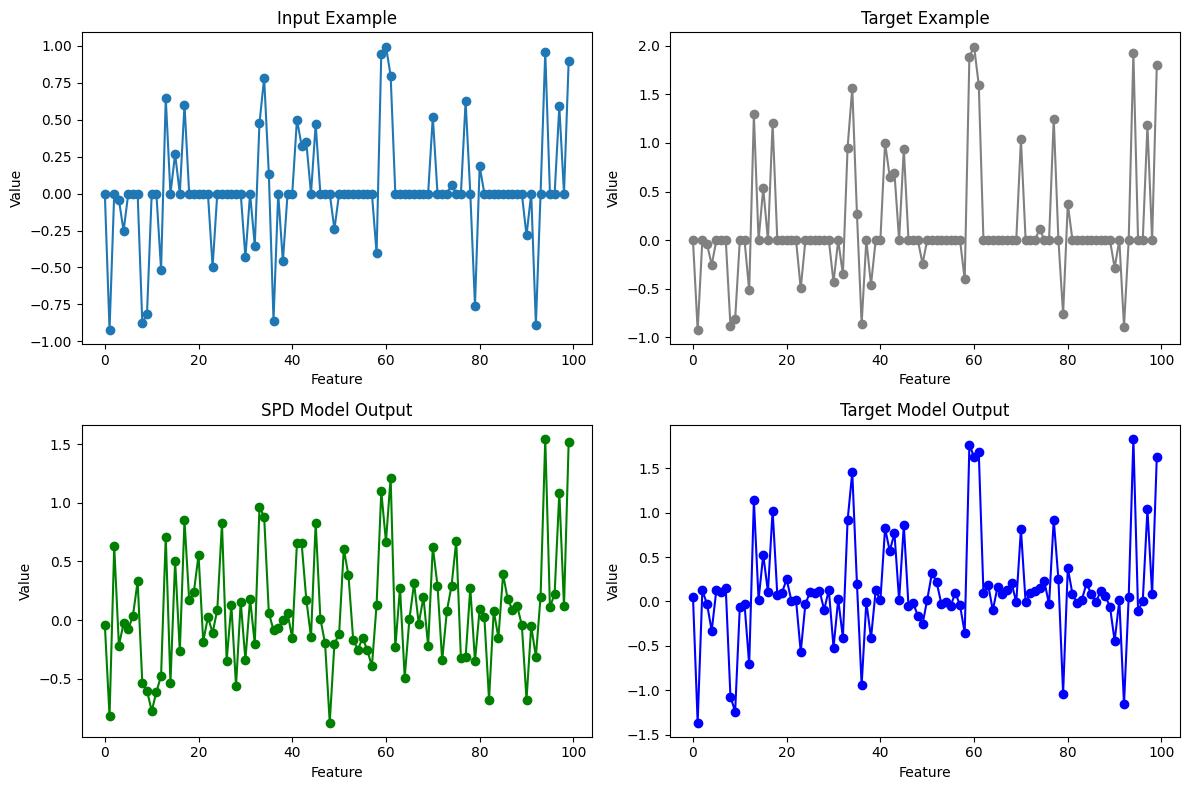

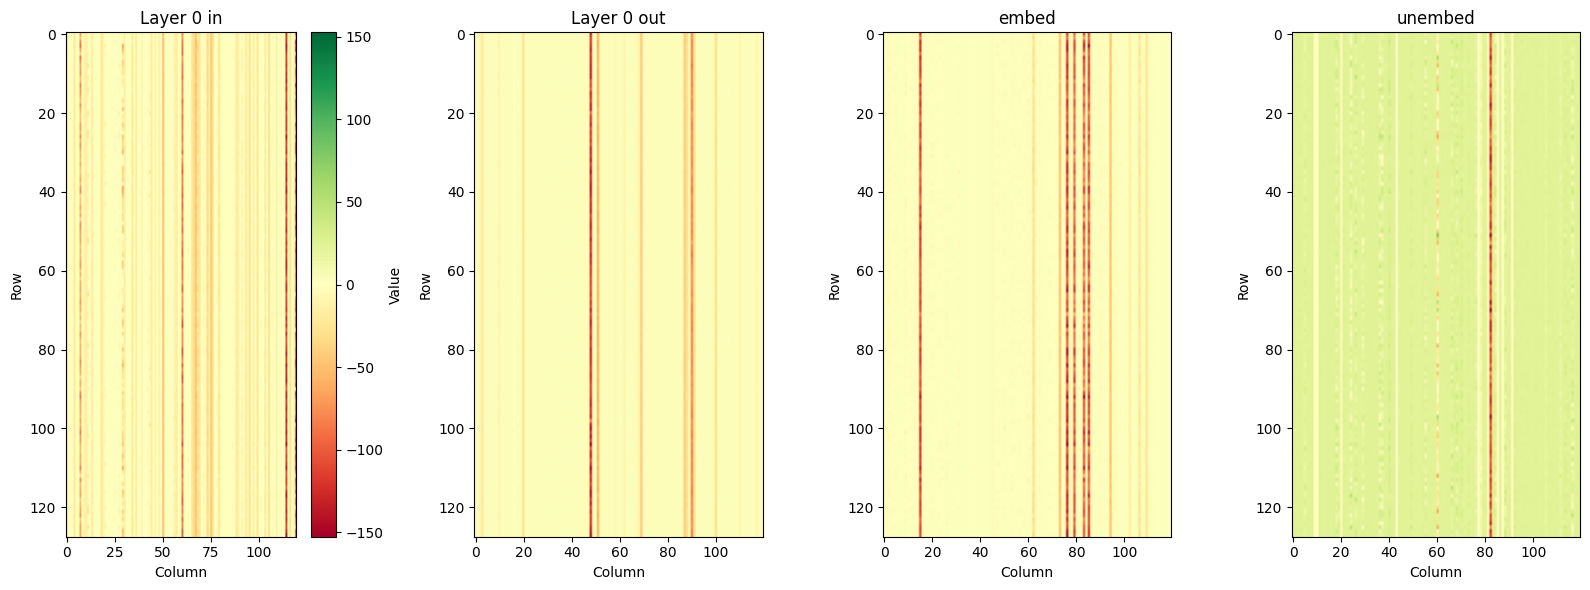

SPD Model Output: 
 tensor([[ 0.2228,  0.8003, -0.1411,  ..., -0.5943, -0.3730,  0.1936],
        [-0.1470,  0.8286,  1.2253,  ...,  0.4497,  0.1940,  0.3133],
        [-0.0100,  0.2878,  1.0943,  ..., -0.5332, -0.5606, -0.1906],
        ...,
        [-0.1681, -0.4059,  0.3088,  ..., -0.0266,  0.0440, -0.2343],
        [ 0.1149,  0.5965, -0.0264,  ...,  0.1216, -1.0151,  0.7593],
        [-0.2337, -0.0451,  0.1824,  ...,  0.1261,  0.1293,  0.7470]],
       device='cuda:0', grad_fn=<MmBackward0>)
Sum of out tensor:  tensor(705.1004, device='cuda:0', grad_fn=<SumBackward0>)
Target Model Output: 
 tensor([[ 0.0051,  1.3364, -0.0156,  ..., -0.0284,  0.0629,  0.2169],
        [-0.0419,  1.4151,  1.6793,  ...,  0.1606,  0.3861,  0.1996],
        [ 0.0978,  0.0966,  0.2176,  ...,  0.0155, -0.0126,  0.0303],
        ...,
        [ 0.0705, -1.1728,  0.0751,  ..., -0.4147,  0.0934,  0.0753],
        [ 0.0033,  1.4472,  0.0077,  ...,  0.1578, -1.0920,  1.2082],
        [-0.3306, -0.0051,  0.0689,

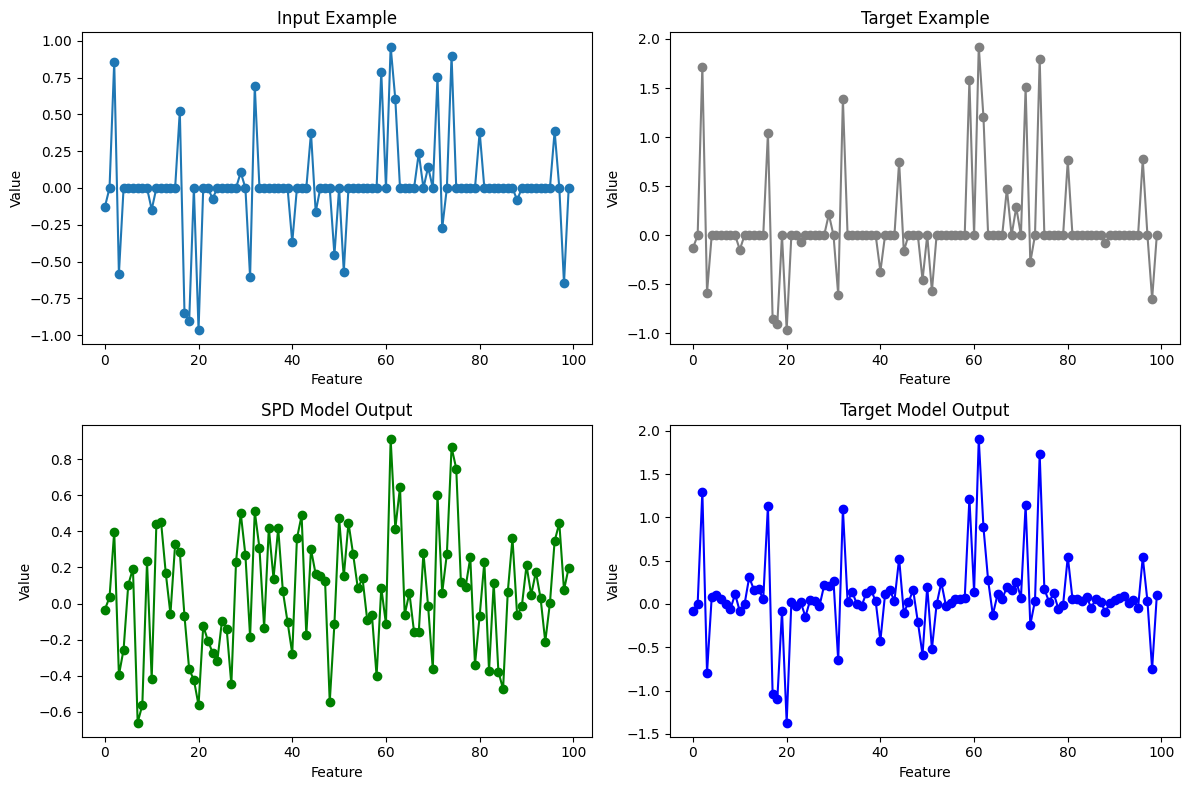

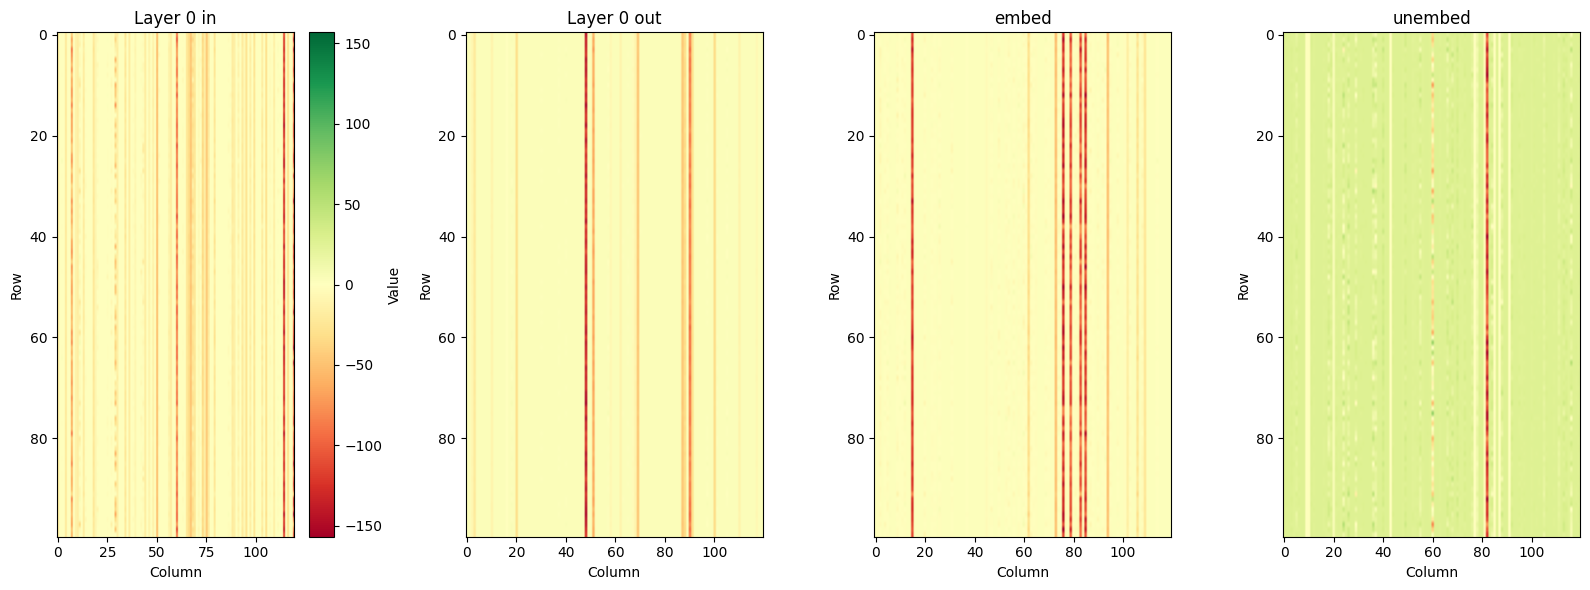

In [40]:
# Setup evaluation dataset and dataloader
eval_dataset = SparseAutoencoderDataset(in_dim=100, n_samples=100, sparsity=0.7, device=DEVICE)
eval_dataloader = DataLoader(eval_dataset, batch_size=100, shuffle=True)
eval_batch = next(iter(eval_dataloader))


def eval_models(dataloader, batch, idx):
  # Evaluate both models
  out_eval = spd_model(batch[idx])
  out_eval_target = spd_model.target_model(batch[idx])
  print("SPD Model Output: \n", out_eval)
  print("Sum of out tensor: ", out_eval.sum())
  print("Target Model Output: \n", out_eval_target)

  visualize_model_outputs(spd_model, dataloader, device=DEVICE, idx=idx)

  # Example usage: visualize all importances in a single figure
  importances = check_masks(batch[0], spd_model)

  # Number of subplots: 2 * num_layers + 2 (for embed/unembed)
  num_layers = spd_model.num_layers
  names = ["in", "out"]
  extra_names = ["embed", "unembed"]
  num_plots = num_layers * 2 + 2

  fig, axes = plt.subplots(1, num_plots, figsize=(4 * num_plots, 6))

  plot_idx = 0
  for layer in range(num_layers):
      for name in names:
          visualize_tensor_grid(
              importances[layer][name],
              title=f"Layer {layer} {name}",
              ax=axes[plot_idx],
              show_colorbar=(plot_idx == 0)
          )
          plot_idx += 1

  for name in extra_names:
      visualize_tensor_grid(
          importances[-1][name],
          title=f"{name}",
          ax=axes[plot_idx],
          show_colorbar=False
      )
      plot_idx += 1

  plt.tight_layout()
  plt.show()


train_batch = next(iter(train_dataloader))
eval_models(train_dataloader, train_batch, 0)
eval_models(eval_dataloader, eval_batch, 0)